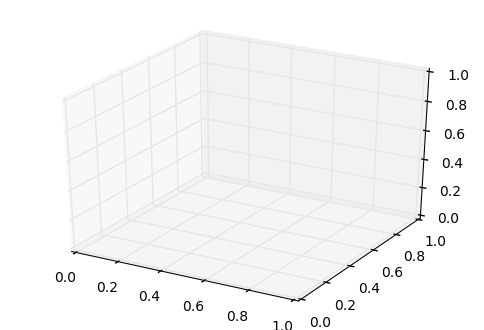

In [10]:
# Setup
# -*- coding: utf-8 -*-
%matplotlib inline

from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as p
import scipy as sp
from sklearn import datasets, linear_model, preprocessing
from sklearn import metrics, neighbors
import sklearn

from mpl_toolkits.mplot3d import Axes3D


In [18]:
# STORE ALL REFORMATTED BATTING DATA AND PITHING DATA W/ SALARIES IN CSV
years = ['2002', '2003', '2004', '2005', '2006', 
         '2007', '2008', '2009', '2010', '2011', 
         '2012', '2013', '2014', '2015', '2016', '2017']

teams = ['ARI','ATL','BAL','BOS','CHC','CHW','CIN','CLE','COL','DET','HOU',
         'KCR','LAA','LAD','MIA','MIL','MIN','NYM','NYY','OAK','PHI','PIT',
         'SDP','SEA','SFG','STL','TBR','TEX','TOR','WSN']

luxury_tax_mult = [1.7, 1.66, 1.62, 1.52, 1.43, 
                   1.32,1.26, 1.2, 1.15, 1.1, 
                   1.1, 1.1, 1.03,1.03, 1.03, 1]

batting_train = p.DataFrame()
pitching_train = p.DataFrame() 
batting_test = p.DataFrame()
pitching_test = p.DataFrame()

for idx, year in enumerate(years):
    # Batting salary data for a year -->
    batting_df = p.read_csv('BattingSalary'+year+'.csv', 
                             engine='python')
    pitching_df = p.read_csv('PitchingSalary'+year+'.csv', 
                             engine='python') 
    
    batting_df['Tm'] = batting_df['Tm'].str.replace('ANA', 'LAA')
    batting_df['Tm'] = batting_df['Tm'].str.replace('MON', 'WSN')
    batting_df['Tm'] = batting_df['Tm'].str.replace('TBD', 'TBR')
    batting_df['Tm'] = batting_df['Tm'].str.replace('FLA', 'MIA')

    pitching_df['Tm'] = pitching_df['Tm'].str.replace('ANA', 'LAA')
    pitching_df['Tm'] = pitching_df['Tm'].str.replace('MON', 'WSN')
    pitching_df['Tm'] = pitching_df['Tm'].str.replace('TBD', 'TBR')
    pitching_df['Tm'] = pitching_df['Tm'].str.replace('FLA', 'MIA')    
    
    batting_df.columns = batting_df.columns.str.replace('Salary▼', 'Salary')
    pitching_df.columns = pitching_df.columns.str.replace('Salary▼', 'Salary')
    
    batting_df['Salary'] = batting_df['Salary'].str.replace('$','')
    pitching_df['Salary'] = pitching_df['Salary'].str.replace('$','')
 
    batting_df['Salary'] = batting_df['Salary'].astype(float)
    pitching_df['Salary'] = pitching_df['Salary'].astype(float)
    
    lux = luxury_tax_mult[idx]
    batting_df['Salary'] *= lux
    pitching_df['Salary'] *= lux
    
    if year == years[0]:
        batting_train = batting_df
        pitching_train = pitching_df
    else:
        batting_train = p.concat([batting_train, batting_df])
        pitching_train = p.concat([pitching_train, pitching_df])

    batting_df.to_csv('BattingStats'+year+'.csv', index=False)
    pitching_df.to_csv('PitchingStats'+year+'.csv', index=False)
        
batting_train.drop(batting_train.columns[[0, 1, -2]], axis=1, inplace=True)
batting_train = batting_train.fillna(0)

pitching_train.drop(pitching_train.columns[[0,1,-1]], axis=1, inplace=True)
pitching_train = pitching_train.fillna(0)

batting_train.to_csv('AllBattingData.csv', index=False)
pitching_train.to_csv('AllPitchingData.csv', index=False)

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

# FORMAT TRAINING DATA FOR BATTING AND PITCHING
batting_train = p.read_csv('AllBattingData.csv')
pitching_train = p.read_csv('AllPitchingData.csv')

# Now remove team for the training data
batting_train.drop(batting_train.columns[[1]], axis=1, inplace=True)
pitching_train.drop(pitching_train.columns[[1]], axis=1, inplace=True)

batting_x = batting_train.drop(['Pos Summary'], axis=1)
batting_x = batting_x[(batting_x['G'] > 100)]
batting_x = batting_x[(batting_x['PA'] > 100)]
batting_y = batting_x[['Salary']]
batting_x = batting_x.drop(['Salary'], axis=1)

pitching_x = pitching_train[(pitching_train['G'] > 20)]
pitching_y = pitching_x[['Salary']]
pitching_x = pitching_x.drop(['Salary'], axis=1) 

batting_train_x, batting_test_x, batting_train_y, batting_test_y = train_test_split(batting_x, batting_y, test_size=0.3, random_state=0)
pitching_train_x, pitching_test_x, pitching_train_y, pitching_test_y = train_test_split(pitching_x, pitching_y, test_size=0.3, random_state=0)

# PREDICT SALARIES BASED OFF OF STATISTICS
batting_regr = linear_model.LinearRegression()
scores = cross_val_score(batting_regr, batting_train_x.values, batting_train_y.values, cv=10)
batting_regr.fit(batting_train_x, batting_train_y)
print(np.mean(scores))
print(batting_regr.score(batting_test_x, batting_test_y))

pitching_regr = linear_model.LinearRegression()
scores = cross_val_score(pitching_regr, pitching_train_x.values, pitching_train_y.values, cv=10)
print(np.mean(scores))

pitching_regr.fit(pitching_train_x.values, pitching_train_y.values.ravel())
print(pitching_regr.score(pitching_test_x, pitching_test_y))

0.40729525127
0.433046310126
0.347002827885
0.358753045411


In [20]:
payment_x = np.zeros((1, 20))

for year in years: 
    year_batting_df = p.read_csv('BattingStats'+year+'.csv', engine='python')
    year_pitching_df = p.read_csv('PitchingStats'+year+'.csv', engine='python')
    year_batting_df.drop(year_batting_df.columns[[0, 1, -2]], axis=1, inplace=True)
    year_batting_df = year_batting_df.fillna(0)
    year_pitching_df.drop(year_pitching_df.columns[[0,1,-1]], axis=1, inplace=True)
    year_pitching_df = year_pitching_df.fillna(0)

    year_batting_df['Pos Summary'] = year_batting_df['Pos Summary'].str.replace('*','')
    year_batting_df['Pos Summary'] = year_batting_df['Pos Summary'].str.replace('/','')
    year_batting_df['Pos Summary'] = year_batting_df['Pos Summary'].str[0:1]
     
    if year == '2017':
        test_success_x = np.zeros((1, 20))
    
    for team in teams:
        year_batting_df = year_batting_df[p.notnull(year_batting_df['Pos Summary'])]
        teamB = year_batting_df[(year_batting_df['Tm'].str.startswith(team))]
        feature_vector = []
        for pos in range(2, 10):
            pos_batting = teamB[(teamB['Pos Summary'].str.startswith(str(pos)))]
            actual_batting_salaries = pos_batting['Salary'].values
            pos_batting.drop(pos_batting.columns[[1,-2, -1]], axis=1, inplace=True)  
            
            if len(pos_batting.values) == 0:
                overpaid = 0.0
                underpaid = 0.0
            else:            
                B_predicted = batting_regr.predict(pos_batting.values) 
                differences = np.ndarray.flatten(B_predicted) - actual_batting_salaries
                overpaid = np.sum(differences[differences > 0])
                underpaid = np.sum(differences[differences < 0])
            feature_vector.append(overpaid)
            feature_vector.append(underpaid)
       
        teamP = year_pitching_df[(year_pitching_df['Tm'].str.startswith(team))]
        # Get starting pitchers
        starting_pitchers = teamP[(teamP['GS'] > 0)]
        starting_pitching_salaries = starting_pitchers['Salary'].values
        starting_pitchers.drop(starting_pitchers.columns[[1, -1]], axis=1, inplace=True)
        P_predicted = pitching_regr.predict(starting_pitchers.values)
        differences = np.ndarray.flatten(P_predicted) - starting_pitching_salaries
        overpaid = np.sum(differences[differences > 0])
        underpaid = np.sum(differences[differences < 0])
        feature_vector.append(overpaid)
        feature_vector.append(underpaid)          
        
        # Relief pitchers
        relief_pitchers = teamP[(teamP['GS'] == 0)]
        relief_pitching_salaries = relief_pitchers['Salary'].values
        relief_pitchers.drop(relief_pitchers.columns[[1, -1]], axis=1, inplace=True)
        P_predicted = pitching_regr.predict(relief_pitchers.values)
        differences = np.ndarray.flatten(P_predicted) - relief_pitching_salaries
        overpaid = np.sum(differences[differences > 0])
        underpaid = np.sum(differences[differences < 0])
        feature_vector.append(overpaid)
        feature_vector.append(underpaid)        
         
        feature_vector = np.asarray(feature_vector)
        B_predicted = p.DataFrame(np.ndarray.flatten(feature_vector))
        
        team_Twenty_Predicted = B_predicted.T
        to_append = team_Twenty_Predicted.values
        
        payment_x = np.vstack([payment_x, to_append]) 
payment_x = payment_x[1:]
payment_x = p.DataFrame(payment_x)
payment_x.to_csv('payment_x.csv', index=False)

/Users/harrisoncaruthers/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/harrisoncaruthers/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/harrisoncaruthers/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [26]:
# PREDICT WINS
payment_x = p.read_csv('payment_x.csv')
teamWins = p.read_csv('teamWins.csv')
teamWins.drop(teamWins.columns[0], axis=1, inplace=True)
years = teamWins.values.tolist()
payment_y = [item for sublist in years for item in sublist]

wins_regr = linear_model.LinearRegression()
# payment_x = sklearn.preprocessing.normalize(payment_x)
# X_scaled = sklearn.preprocessing.scale(payment_x)
scores = cross_val_score(wins_regr, payment_x, payment_y, cv=5)
print np.mean(scores)


from sklearn.decomposition import PCA as sklearnPCA
pca = sklearnPCA(n_components=3)
transformed = p.DataFrame(lda.fit_transform(payment_x, payment_y))

from sklearn import svm
clf = svm.NuSVR(kernel='rbf',C=1.0, nu=0.1)
scores = cross_val_score(clf, payment_x, payment_y, cv=5)
print(np.mean(scores))


# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(transformed[0], transformed[1], transformed[2])




# test_success_y = np.asarray(success_y_orig[:30])

# actual = test_success_y.T
# predicted = wins_regr.predict(test_success_x).T

# sidebyside = np.vstack((actual, predicted))
# display(p.DataFrame(sidebyside))

# print(metrics.mean_squared_error(actual, predicted))
# print(metrics.r2_score(actual, predicted))


# plt.plot(np.arange(0,30), actual, 'bo')

# plt.plot(np.arange(0,30), predicted, 'ro')
# plt.show()


# print(metrics.explained_variance_score(actual, predicted))


-0.0209206772856
-0.00559513352078


/Users/harrisoncaruthers/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/harrisoncaruthers/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


[ 85.28546129  84.87383503  86.81243489  87.56874531  88.25734658
  83.2290748   87.9274893   85.02543627  83.8404799   88.14848956
  87.57363299  85.73625771  80.31084163  88.85787096  86.26297456
  82.41525665  86.25033177  82.82169089  86.51463054  74.81178445
  76.18269196  84.27129256  82.60783149  89.71385782  90.31438674
  86.79080761  82.9914302   87.49720411  90.56144036  89.26362201]


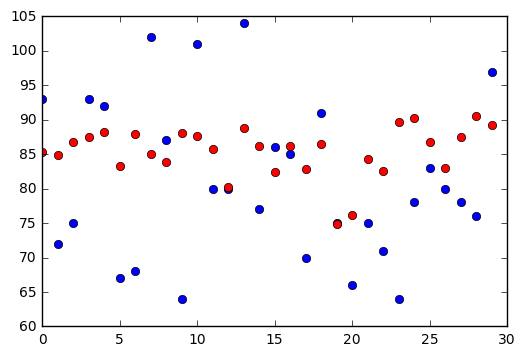

139.999968881
-0.0892113761512


In [21]:
# NEURAL NETWORK

from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPRegressor
from scipy import stats
from sklearn.grid_search import RandomizedSearchCV

full_twenty = p.read_csv('FullTwenty.csv')
test_success_x = p.read_csv('TestSuccessX.csv')

# Standardize the data
train_x = full_twenty
scaler = StandardScaler()  
scaler.fit(train_x)  
train_x = scaler.transform(train_x)
test_success_x = scaler.transform(test_success_x)

nn = MLPRegressor(max_iter=100000, hidden_layer_sizes=(50), activation='tanh', learning_rate_init=0.0001)

rs = RandomizedSearchCV(nn, param_distributions={
    'learning_rate_init': stats.uniform(0.001, 0.05)
    
    })
rs.fit(train_x, success_y)

# nn.fit(train_x, success_y)

predictions = rs.predict(test_success_x)
print(predictions)

plt.plot(np.arange(0,30), test_success_y, 'bo')
plt.plot(np.arange(0,30), predictions, 'ro')
plt.show()

print(metrics.mean_squared_error(actual, predictions))
print(metrics.r2_score(actual, predictions))


In [40]:
# SVM


NameError: name 'train_x' is not defined

In [39]:
predictions = clf.predict(test_success_x)


print(metrics.mean_squared_error(actual, predictions))
print(metrics.r2_score(actual, predictions))

NameError: name 'clf' is not defined